# Example of applications of the zigzag computation in honey bee sperm analysis

This Jupyter notebook includes some examples of applications of the zigzag persistence in the sperm analysis of honey bee drones. In broad terms, we present two applications: detection of static spermatozoa and tracking of motile spermatozoa.

The [CASABee software](https://github.com/jodivaso/CASABee) allows one to automatically analyze this kind of videos using OpenCV, the Hough transform and image processing techniques. We show here how the zigzag method can also be employed for this task. 


#### Original video used for the examples
The video used for the following examples can be downloaded [from here](https://unirioja-my.sharepoint.com/:u:/g/personal/jodivaso_unirioja_es/EfgFsIB-tRFLhaJHvF3weVQBITPFS__IhxvcTLSozxJIQg?e=Yocxe6). Please, download it and unzip it (its size is approximately 135MB) in the same folder of this Jupyter notebook.

### Example 1: detection of static spermatozoa

We propose to use zigzag persistence combined with morphological operations. The underlying idea follows: we consider the intersection of all frames. Then, we apply erosions and dilations, producing a sequence of binary images. The barcode obtained by computing the zigzag persistence of degree 0 of this sequence allows one to identify the static spermatozoa as the components.

In [1]:
# All this code is the same as the one presented for the Zigzag computation.
import dionysus as d
import matplotlib.pyplot as plt

aux_zz = []
all_generator_list = []
f = []

def vertexNumber(row,colum,numCols):
    return row*numCols+colum

def addSimplexToSet (s, l):
    l.add(tuple(s))

def binaryImageToSimplicialComplexList(img):
    rowNum = img.shape[0]
    colNum = img.shape[1]
    simplices0 = set()
    simplices1 = set()
    simplices2 = set()
    for j in range(0,rowNum):
        for i in range(0,colNum):
            if (img[j,i]==255):
                v = vertexNumber(j,i,colNum)
                addSimplexToSet([v],simplices0)
                if (j < rowNum-1) and (img[j+1,i] == 255):
                    v10 = vertexNumber(j+1,i,colNum)
                    addSimplexToSet([v,v10],simplices1)
                if (i < colNum-1) and (img[j,i+1] == 255):
                    v01 = vertexNumber(j,i+1,colNum)
                    addSimplexToSet([v,v01],simplices1)                      
                if (i < colNum-1) and (j < rowNum-1) and (img[j+1,i+1] == 255) and (img[j+1,i] == 0) and (img[j,i+1] == 0):
                    v11 = vertexNumber(j+1,i+1,colNum)
                    addSimplexToSet([v,v11],simplices1)
                if (i > 0) and (j < rowNum-1) and (img[j+1,i-1] == 255) and (img[j,i-1] == 0) and (img[j+1,i] == 0):
                    v1_1 = vertexNumber(j+1,i-1,colNum)
                    addSimplexToSet([v,v1_1],simplices1)
                if (i < colNum-1) and (j < rowNum-1) and (img[j+1,i+1] == 255) and (img[j+1,i] == 255) and (img[j,i+1] == 255):
                    v11 = vertexNumber(j+1,i+1,colNum)
                    addSimplexToSet([v,v11],simplices1)
                    addSimplexToSet([v,v01,v11],simplices2)
                    addSimplexToSet([v,v10,v11],simplices2)
    return simplices0,simplices1,simplices2

def binaryImageToSimplicialComplex(img):
    simplices0,simplices1,simplices2 = binaryImageToSimplicialComplexList(img)
    simplices0 = sorted(simplices0, key=lambda x: (x[0]))
    for i in range(len(simplices0)):
        simplices0[i] = list(simplices0[i])
    simplices1 = sorted(simplices1, key=lambda x: (x[0],x[1]))
    for i in range(len(simplices1)):
        simplices1[i] = list(simplices1[i])
    simplices2 = sorted(simplices2, key=lambda x: (x[0],x[1],x[2])) 
    for i in range(len(simplices2)):
        simplices2[i] = list(simplices2[i])
    return simplices0+simplices1+simplices2

def simplicesListToZigzagFiltration(slist,n):
    total_simplices_l = []
    total_simplices_set = set()
    indices_l = []
    previous_simplices_l = []
    previous_simplices_set = set()    
    slistaux = []
    aux = []
    
    for sc in slist:
        if n==0:
            aux = sorted(sc, key=lambda x: (x[0]))
        elif n==1:
            aux = sorted(sc, key=lambda x: (x[0],x[1]))
        elif n==2:
            aux = sorted(sc, key=lambda x: (x[0],x[1],x[2]))
        elif n==3:
            aux = sorted(sc, key=lambda x: (x[0],x[1],x[2],x[3]))
    
        for i in range(len(aux)):
            aux[i] = list(aux[i])
        slistaux.append(aux)        
    
    for i,sc in enumerate(slist):
        for s in slistaux[i]:
            if (tuple(s) in total_simplices_set) :
                if not (tuple(s) in previous_simplices_set):
                    index = total_simplices_l.index(s)
                    indices_l[index].append(i)          
            else:
                total_simplices_l.append(s)
                total_simplices_set.add(tuple(s))
                indices_l.append([i])
        for s in previous_simplices_l:
            if not (tuple(s) in sc):
                index = total_simplices_l.index(s)
                indices_l[index].append(i)
        previous_simplices_set = sc
        previous_simplices_l = slistaux[i]   
        
    return total_simplices_l,indices_l
       
def imageListToSimplicialComplexList (imgList):
    
    l0 = []
    l1 = []
    l2 = []
    l3 = []
    for img in imgList:
        sc0,sc1,sc2 = binaryImageToSimplicialComplexList(img)
        l0.append(sc0)
        l1.append(sc1)
        l2.append(sc2)
        l3.append(set())
        
    for r,img in enumerate(imgList):        
        rowNum = img.shape[0]
        colNum = img.shape[1]
        for j in range(0,rowNum):
            for i in range(0,colNum):
                isDiag = 0
                isCorner = 0
                if (img[j,i]==255):
                    if (i < colNum-1) and (j < rowNum-1) and (img[j+1,i+1]==255) and (img[j,i+1]==0) and (img[j+1,i]==0):
                        isDiag = 1
                        diagEdge = [vertexNumber(j,i,colNum),vertexNumber(j+1,i+1,colNum)]
                    elif (i > 0) and (j < rowNum-1) and (img[j+1,i-1] == 255) and (img[j,i-1] == 0) and (img[j+1,i] == 0):
                        isDiag = -1
                        diagEdge = [vertexNumber(j,i,colNum),vertexNumber(j+1,i-1,colNum)]
                    elif (i < colNum-1) and (j < rowNum-1) and (img[j+1,i] == 255) and (img[j,i+1] == 255) and (img[j+1,i+1] == 0):
                        isCorner = 1
                        
                    elif (i > 0) and (j < rowNum-1) and (img[j,i-1] == 255) and (img[j+1,i] == 255) and (img[j+1,i-1] == 0):
                        isCorner = -1
                        
                    if isDiag !=0 or isCorner!=0:
                        imgListAux = []
                        if (r< len(imgList)-1):
                            imgListAux.append([r+1,imgList[r+1]])
                        if (r > 0):
                            imgListAux.append([r-1,imgList[r-1]])
                        for k,img1 in imgListAux:
                            if isDiag==1 and (img1[j,i]==255) and (img1[j+1,i+1]==255) and (img1[j,i+1]==255) and (img1[j+1,i]== 0):
                                addSimplexToSet(diagEdge,l1[k])
                                addSimplexToSet([diagEdge[0],diagEdge[0]+1,diagEdge[1]],l2[k])
                                
                            elif isDiag==1 and (img1[j,i]==255) and (img1[j+1,i+1]==255) and (img1[j,i+1]==0) and (img1[j+1,i]== 255):   
                                addSimplexToSet(diagEdge,l1[k])
                                addSimplexToSet([diagEdge[0],diagEdge[1]-1,diagEdge[1]],l2[k])
                            
                            elif isDiag==-1 and (img1[j,i]==255) and (img1[j+1,i-1]==255) and (img1[j,i-1]==255) and (img1[j+1,i]== 0):
                                addSimplexToSet(diagEdge,l1[k])
                                addSimplexToSet([diagEdge[0]-1,diagEdge[0],diagEdge[1]],l2[k])
                               
                            elif isDiag==-1 and (img1[j,i]==255) and (img1[j+1,i-1]==255) and (img1[j,i-1]==0) and (img1[j+1,i]== 255):
                                addSimplexToSet(diagEdge,l1[k])
                                addSimplexToSet([diagEdge[0],diagEdge[1],diagEdge[1]+1],l2[k])

                            elif isDiag==-1 and (img1[j,i]==255) and (img1[j+1,i-1]==255) and (img1[j,i-1]==255) and (img1[j+1,i]== 255):
                                addSimplexToSet(diagEdge,l1[k])
                                addSimplexToSet([diagEdge[0]-1,diagEdge[0],diagEdge[1]],l2[k])
                                addSimplexToSet([diagEdge[0],diagEdge[1],diagEdge[1]+1],l2[k])
                                addSimplexToSet([diagEdge[0]-1,diagEdge[0],diagEdge[1],diagEdge[1]+1],l3[k])
                                
                            elif isCorner ==1 and img1[j,i]==0 and img1[j,i+1]==255 and img1[j+1,i]==255 and img1[j+1,i+1]==255:
                                diagEdge = [vertexNumber(j,i+1,colNum),vertexNumber(j+1,i,colNum)]
                                addSimplexToSet([diagEdge[0]-1],l0[k])
                                addSimplexToSet(diagEdge,l1[k])
                                addSimplexToSet([diagEdge[0]-1,diagEdge[0]],l1[k])
                                addSimplexToSet([diagEdge[0]-1,diagEdge[1]],l1[k])
                                addSimplexToSet([diagEdge[0]-1,diagEdge[0],diagEdge[1]],l2[k])
                                addSimplexToSet([diagEdge[0],diagEdge[1],diagEdge[1]+1],l2[k])
                                addSimplexToSet([diagEdge[1]+1],l0[r])
                                addSimplexToSet(diagEdge,l1[r])
                                addSimplexToSet([diagEdge[0],diagEdge[1]+1],l1[r])
                                addSimplexToSet([diagEdge[1],diagEdge[1]+1],l1[r])
                                addSimplexToSet([diagEdge[0]-1,diagEdge[0],diagEdge[1]],l2[r])
                                addSimplexToSet([diagEdge[0],diagEdge[1],diagEdge[1]+1],l2[r])
                                
                            elif isCorner ==-1 and img1[j,i]==0 and img1[j,i-1]==255 and img1[j+1,i]==255 and img1[j+1,i-1]==255:
                                diagEdge = [vertexNumber(j,i-1,colNum),vertexNumber(j+1,i,colNum)]
                                addSimplexToSet([diagEdge[0]+1],l0[k])
                                addSimplexToSet(diagEdge,l1[k])
                                addSimplexToSet([diagEdge[0],diagEdge[0]+1],l1[k])
                                addSimplexToSet([diagEdge[0]+1,diagEdge[1]],l1[k])

                                addSimplexToSet([diagEdge[0],diagEdge[0]+1,diagEdge[1]],l2[k])
                                addSimplexToSet([diagEdge[0],diagEdge[1]-1,diagEdge[1]],l2[k])
                                addSimplexToSet([diagEdge[1]-1],l0[r])
                                addSimplexToSet(diagEdge,l1[r])
                                addSimplexToSet([diagEdge[0],diagEdge[1]-1],l1[r])
                                addSimplexToSet([diagEdge[1]-1,diagEdge[1]],l1[r])
                                
                                addSimplexToSet([diagEdge[0],diagEdge[0]+1,diagEdge[1]],l2[r])
                                addSimplexToSet([diagEdge[0],diagEdge[1]-1,diagEdge[1]],l2[r])
    return l0,l1,l2,l3

def imageListToZigzagFiltration(imageList):
                                
    l0,l1,l2,l3 = imageListToSimplicialComplexList(imageList)                     
    zz_list0,zz_indices0 = simplicesListToZigzagFiltration(l0,0)
    zz_list1,zz_indices1 = simplicesListToZigzagFiltration(l1,1)
    zz_list2,zz_indices2 = simplicesListToZigzagFiltration(l2,2)
    zz_list3,zz_indices3 = simplicesListToZigzagFiltration(l3,3)
    
    simplices = zz_list0+zz_list1+zz_list2+zz_list3
    indices = zz_indices0+zz_indices1+zz_indices2+zz_indices3
    return simplices,indices

def detail(i,t,d,zz,cells):
    global aux_zz
    global all_generator_list, f
    
    aux_zz = []  
    for z in zz:
        aux_zz.append(z)        
    if len(aux_zz)!=0:
        aux_zz_last = aux_zz[len(aux_zz)-1]
    else:
        aux_zz_last = []
    z_list = []
    for x in aux_zz_last:
        z_list.append([x.element, f[cells[x.index]]])
    all_generator_list.append(z_list)    
    
def scListZigzagHomology(times):
    global aux_zz
    global all_generator_list, f
                                                    
    aux_zz = []
    all_generator_list = []

    zz, dgms, cells = d.zigzag_homology_persistence(f, times  , callback = detail)
    return dgms, all_generator_list     
        
def imageListZigzagHomology (imageList):
    global f
    
    simplices,times = imageListToZigzagFiltration(imageList)
    f = d.Filtration(simplices)
 
    return scListZigzagHomology(times)

def printGenerator (glist):
    return (' + '.join("%d * %s" % (pair[0], [v for v in pair[1]]) for pair in glist))


def plot_zigzag_bars(dgm, dimension, times, generator_list, interval_l=1, gen_l1=1, gen_l2=0, printGenerators=True,
                     order='birth', ax=None, show= True, **bar_style):
    """
    Plot the barcode.
    Arguments:
        dgm (Diagram): See for example `init_diagrams`.
    Keyword Arguments:
        order (str): How to sort the bars, either 'death' or 'birth'
                     (Default: 'birth')
        show (bool): Display the plot. (Default: False)
        ax (AxesSubplot): Axes that should be used for plotting (Default: None)
        **bar_style: Arguments passed to `ax.plot` for style of the bars.
                     (Defaults: color='b')
    """

    bar_kwargs = {'color': 'b'}
    bar_kwargs.update(bar_style)

    if order == 'death':
        generator = enumerate(sorted(dgm, key=lambda p: p.death))
    else:
        generator = enumerate(dgm)

    if ax is None:
        ax = plt.axes()

    maxi = max(times, key=max)
    maxi = maxi[len(maxi) - 1]

    ax.set_xlim(-0.5, maxi + 1.5)

    result_generators = []

    i = 0
    for j, p in generator:
        if p.death == float('inf'):
            de = maxi + 1
        else:
            de = p.death
        if de - p.birth >= interval_l:
            g = generator_list[p.data]
            if (gen_l1 <= len(g)) and (gen_l2 == 0 or len(g) <= gen_l2):
                if p.death == float('inf'):
                    ax.plot([p.birth, maxi + 1], [i, i], **bar_kwargs)
                    plt.scatter([p.birth], [i], color="blue", edgecolor="blue")
                    result_generators.append(generator_list[p.data])
                    if printGenerators:
                        plt.text(p.birth, i + 0.2, printGenerator(generator_list[p.data]))
                else:
                    ax.plot([p.birth, p.death - 0.05], [i, i], **bar_kwargs)
                    plt.scatter([p.birth], [i], color="blue", edgecolor="blue")
                    plt.scatter([p.death], [i], color="white", edgecolor="blue")
                    result_generators.append(generator_list[p.data])
                    if printGenerators:
                        plt.text(p.birth, i + 0.2, printGenerator(generator_list[p.data]))
                i = i + 1

    plt.text(0, i - 0.2, "Barcode of dimension " + str(dimension))
    ax.set_ylim(-1, i)
    plt.yticks(range(0,i))
    plt.xticks(range(0,maxi+2))
    labels = [i for i in range(0,maxi+2)]
    labels[maxi+1]="$+\infty$"
    ax.set_xticklabels(labels, fontsize=12)
    ax.get_xticklabels()[-1].set_fontsize(16)
    ax.set_xticklabels(labels)

    if show:
        plt.show()
        
    return result_generators # len(result_generators)

def imageListZigzagPlotBar (imageList,dimensions=[0,1],interval_l=1, gen_l1=1, gen_l2=0,printGenerators=True):
    global f

    simplices,times = imageListToZigzagFiltration(imageList)
    f = d.Filtration(simplices)
    dgms, generator_list = scListZigzagHomology(times)
    
    result_generators = []
    
    for i in dimensions:
        dgm = dgms[i]
        result_generators.append(plot_zigzag_bars(dgm, i, times, generator_list, interval_l, gen_l1, gen_l2,printGenerators))
        
    return result_generators

In [2]:
# This code is taken from the CASABee software

import sys
import os
import math
import cv2 as cv
import numpy as np


filterKernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
morphKernel = np.ones((3, 3), np.uint8)
horizontalLinesKernel = np.array([[-1, -1, -1], [2, 2, 2], [-1, -1, -1]])
verticalLinesKernel = np.array([[-1, 2, -1], [-1, 2, -1], [-1, 2, -1]])
kernel45Lines = np.array([[-1, -1, 2], [-1, 2, -1], [2, -1, -1]])
kernel_45Lines = np.array([[2, -1, -1], [-1, 2, -1], [-1, -1, 2]])

minRadius=35
maxRadius=50
param1=80
param2=35
mediumCellSize= 300
micronsPerPixel=0.59
cameraDepth=10
diluent = 0
th=70
mediumCellSize = mediumCellSize / micronsPerPixel
minimumCellSize = mediumCellSize * 0.20  # ponerlo como parámetro ?
minArea = minimumCellSize * 4 #/ micronsPerPixel

def convolve(image, kernel):
        # https://www.pyimagesearch.com/2016/07/25/convolutions-with-opencv-and-python/
        # grab the spatial dimensions of the image, along with
        # the spatial dimensions of the kernel
    (iH, iW) = image.shape[:2]
    (kH, kW) = kernel.shape[:2]
         # allocate memory for the output image, taking care to
            # "pad" the borders of the input image so the spatial
            # size (i.e., width and height) are not reduced
    pad = (kW - 1) // 2
    image = cv.copyMakeBorder(image, pad, pad, pad, pad,cv.BORDER_REPLICATE)
    output = np.zeros((iH, iW), dtype="float32")
        # loop over the input image, "sliding" the kernel across
            # each (x, y)-coordinate from left-to-right and top to
            # bottom
    for y in np.arange(pad, iH + pad):
        for x in np.arange(pad, iW + pad):
            # extract the ROI of the image by extracting the
            # *center* region of the current (x, y)-coordinates
            # dimensions
            roi = image[y - pad:y + pad + 1, x - pad:x + pad + 1]
                # perform the actual convolution by taking the
                # element-wise multiplicate between the ROI and
                # the kernel, then summing the matrix
            k = (roi * kernel).sum()
                # store the convolved value in the output (x,y)-
                # coordinate of the output image
            output[y - pad, x - pad] = k
    return output

def analyzeFrame(frame):

    height, width, depth = frame.shape
        #iimg = np.full((height, width), 255, np.uint8)
    w = width + 50
    h = height + 50

    image = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    cv.normalize(image, image, 0, 255, cv.NORM_MINMAX)
    image = cv.filter2D(image, -1, filterKernel)
    img_border = cv.copyMakeBorder(image, 50, 50, 50, 50, cv.BORDER_REFLECT)
    circles = cv.HoughCircles(img_border, cv.HOUGH_GRADIENT, 1, 25, param1=80, param2=35, minRadius=minRadius,
                                  maxRadius=maxRadius)
    circles2 = []
    if circles is not None:
        circles = np.uint16(np.around(circles))
        # I choose the circles that are inside the image
        
        for (x, y, r) in circles[0, :]:
            if ((x >= 50) and x <= w and (y >= 50) and y <= h):
                mask = np.zeros((height, width), np.uint8)
                cv.circle(mask, (x, y), r, 255, -1)
                points = np.transpose(np.where(mask == 255))
                sum = 0
                for (a, b) in points:
                    sum = sum + img_border[a][b]
                # suma = suma + img_border[a][b][0] + img_border[a][b][1] + img_border[a][b][2] # Aqui mejor poner algo como que > 50% pixeles tienen alta intensidad
                if (sum <= 128 * 0.6 * len(points)):
                    circles2.append([x - 50, y - 50, r])


    return circles2

In [3]:
# Code for the algorithm to detect static spermatozoa using zigzag persistence.

def imgUmbAnalyzeForZigzag(img_umb, i): 
    # Auxiliary function used to compute the image obtained by applying i erosions followed by i − 1 dilations
    # (and the rest of steps of algorithm)
        
    frameList = []
    contours = []
    circleList = []
    cimgList = []
    image = img_umb
    height, width = image.shape
    iimg = np.full((height, width), 255, np.uint8)
    w = width + 50
    h = height + 50
    
    cimg = cv.cvtColor(img_umb, cv.COLOR_GRAY2BGR)
    cimg1 = cv.cvtColor(img_umb, cv.COLOR_GRAY2BGR)  
    

    numOperations = i 

    if (i>0):
        img_umb2 = cv.dilate(img_umb,morphKernel)
        img_umb2 = cv.dilate(img_umb2,morphKernel)
        
        for i in range(numOperations):
            img_umb2 = cv.erode(img_umb2,morphKernel)
        
        for i in range(0,numOperations-1):
            img_umb2 = cv.dilate(img_umb2,morphKernel)
    
        img_umb = cv.bitwise_and(img_umb, cv.bitwise_not(img_umb2))
    

    # We do the same postprocessing as in the CASABee software
    circles = cv.HoughCircles(img_umb, cv.HOUGH_GRADIENT, 1, 25, param1=50, param2=20, minRadius=10,
                                  maxRadius=maxRadius)
    if circles is not None:
        circles = np.uint16(np.around(circles))

        for (x, y, r) in circles[0, :]:
                # We draw circles in black, with radius 13:
            cv.circle(img_umb, (x, y), r - 3, 0, 13)

            # I compute contours again

        contours, hierarchy = cv.findContours(img_umb, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

            # I choose those that correspond to thin lines
        contours2 = []
        for c in contours:
            area = cv.contourArea(c)
            minRectBox = cv.minAreaRect(c)
            minRectArea = cv.contourArea(cv.boxPoints(minRectBox))
            if (area > minArea) and ((area / minRectArea) < 0.3): # and minRectArea > boundingBoxMinArea:  # and (convexHullArea > 3000)
                contours2.append(c)

            # For each contour corresponding to a thin line, I compute the contour extrems,
            # I determine a 20x20 square over the image and I look for horizontal, vertical, 45 or -45 lines
            # Depending on the type of lines found in the square, I determine a rectangle for each extrem where I look
            # for white pixels. For each white pixel found I add a line between this pixel and the corresponding extrem

        lines = []

        for c in contours2:

            extLeft = tuple(c[c[:, :, 0].argmin()][0])
            extRight = tuple(c[c[:, :, 0].argmax()][0])
            extTop = tuple(c[c[:, :, 1].argmin()][0])
            extBot = tuple(c[c[:, :, 1].argmax()][0])
            ext = [extLeft, extRight, extTop, extBot]
            xLeft = extLeft[0]
            yLeft = extLeft[1]
            xRight = extRight[0]
            yRight = extRight[1]
            xTop = extTop[0]
            yTop = extTop[1]
            xBot = extBot[0]
            yBot = extBot[1]

                # I determine the coordinages of the four rectangles where I will look for white pixels
            rectangles = [[xLeft - 30, xLeft, yLeft, yLeft], [xRight, xRight + 30, yRight, yRight],
                              [xTop, xTop, yTop - 30, yTop], [xBot, xBot, yBot, yBot + 30]]
            i = 0
            for y, x in ext:
                    # I discard extrems which are closed to the borders
                if ((x >= 50) and x <= h and (y >= 50) and y <= w):

                    square = img_umb[x - 10:x + 11, y - 10:y + 11]

                    coh = convolve(square, horizontalLinesKernel)
                    cov = convolve(square, verticalLinesKernel)
                    co45 = convolve(square, kernel45Lines)
                    co_45 = convolve(square, kernel_45Lines)
                    if ((coh > 700).sum() > 2):
                        if (i == 0):
                            rectangles[i][2] = yLeft - 15
                            rectangles[i][3] = yLeft + 15
                        elif (i == 1):
                            rectangles[i][2] = yRight - 15
                            rectangles[i][3] = yRight + 15
                    if ((cov > 700).sum() > 2):
                        if (i == 2):
                            rectangles[i][0] = xTop - 15
                            rectangles[i][1] = xTop + 15
                        elif (i == 3):
                            rectangles[i][0] = xBot - 15
                            rectangles[i][1] = xBot + 15
                    if ((co45 > 700).sum() > 2):
                        if (i == 0):
                            rectangles[i][3] = yLeft + 30
                        elif (i == 1):
                            rectangles[i][2] = yRight - 30
                        elif (i == 2):
                            rectangles[i][1] = xTop + 30
                        elif (i == 3):
                            rectangles[i][0] = xBot - 30
                    if ((co_45 > 700).sum() > 2):

                        if (i == 0):
                            rectangles[i][2] = yLeft - 30
                        elif (i == 1):
                            rectangles[i][3] = yRight + 30
                        elif (i == 2):
                            rectangles[i][0] = xTop - 30
                        elif (i == 3):
                            rectangles[i][1] = xBot + 30
                i = i + 1

            rectangles_im = [img_umb[rectangles[0][2]:rectangles[0][3], rectangles[0][0]:rectangles[0][1]],
                                 img_umb[rectangles[1][2]:rectangles[1][3], rectangles[1][0]:rectangles[1][1]],
                                 img_umb[rectangles[2][2]:rectangles[2][3], rectangles[2][0]:rectangles[2][1]],
                                 img_umb[rectangles[3][2]:rectangles[3][3], rectangles[3][0]:rectangles[3][1]]]

            for k in range(4):
                rectanglek = rectangles[k]
                rectangles_imk = rectangles_im[k]
                extk = ext[k]

                for i in range(rectangles_imk.shape[0]):
                    for j in range(rectangles_imk.shape[1]):
                        if (rectangles_imk[i, j] == 255):
                            l = [[extk[0], extk[1]], [rectanglek[0] + j, rectanglek[2] + i]]
                            lines.append(l)

            # I draw the lines and compute contours again
        line_thickness = 3
        for l in lines:
            cv.line(img_umb, (l[0][0], l[0][1]), (l[1][0], l[1][1]), 255, thickness=line_thickness)

    contours, hierarchy = cv.findContours(img_umb, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

        # I choose those corresponding to thin lines
    contours2 = []

    for c in contours:
        area = cv.contourArea(c)
        minRectBox = cv.boxPoints(cv.minAreaRect(c))
        ax1 = np.sqrt(np.sum(np.square(minRectBox[0] - minRectBox[1])))
        ax2 = np.sqrt(np.sum(np.square(minRectBox[1] - minRectBox[2])))
        minRectArea = cv.contourArea(minRectBox)
        if ((ax1 > maxRadius * 2 + 10) or (ax2 > maxRadius * 2 + 10)) \
                    and (area > minArea) and ((area / minRectArea) < 0.3):  # and minRectArea > boundingBoxMinArea: 
            # and (convexHullArea > 3000)
            contours2.append(c)


    imgContours = np.zeros((img_umb.shape[0], img_umb.shape[1]), dtype=np.uint8)
    imgContours = cv.cvtColor(imgContours, cv.COLOR_GRAY2BGR)
    cv.drawContours(imgContours, contours2, -1, (255, 255, 255), thickness=2)
    cv.drawContours(imgContours, contours2, -1, (255, 255, 255), thickness=cv.FILLED)
    imgContours = cv.cvtColor(imgContours, cv.COLOR_BGR2GRAY)   
    return contours2, imgContours

def zigzagPersistenceStaticDetection(video):
    
    vidcap = cv.VideoCapture(video)
    success, image = vidcap.read()

    frameList = []
    contours = []
    circleList = []
    cimgList = []
    height, width, depth = image.shape
    iimg = np.full((height, width), 255, np.uint8)
    w = width + 50
    h = height + 50
    
    # We consider the intersection of the enhanced binary images of all frames, as in the CASABee software

    while success:
        frameList.append(image)
        success, image = vidcap.read()

    vidcap.release()

    for frame in frameList:
        circleList.append(analyzeFrame(frame))
        cimgList.append(frame)
        image = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
        cv.normalize(image, image, 0, 255, cv.NORM_MINMAX)
        frame = cv.filter2D(image, -1, filterKernel)
        threshold, img_umb = cv.threshold(frame, th, 255, cv.THRESH_BINARY)
        img_umb = cv.dilate(img_umb, morphKernel)
        img_umb = cv.dilate(img_umb, morphKernel)
        img_umb = cv.dilate(img_umb, morphKernel)
        iimg = cv.bitwise_and(iimg, img_umb)

    img = cv.erode(iimg, morphKernel)
    
    contours, hierarchy = cv.findContours(img, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    contours1 = []

    for c in contours:
        area = cv.contourArea(c)
        minRectBox = cv.minAreaRect(c)
        minRectArea = cv.contourArea(cv.boxPoints(minRectBox))
        if (area < minArea) or ((area / minRectArea) > 0.3): # or minRectArea < boundingBoxMinArea:  #
            contours1.append(c)

    cimg_umb = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
    cv.drawContours(cimg_umb, contours1, -1, (0, 0, 0), thickness=cv.FILLED)
    img_umb = cv.cvtColor(cimg_umb, cv.COLOR_BGR2GRAY)

    # We compute the images by applying i erosions and i-1 dilations (and the other steps of the algorithm)

    zigzagImageList = []
    contoursCB = []

    for i in range(0,11):
        if (i==0):
            contoursCB, imgContoursCB = imgUmbAnalyzeForZigzag(img_umb,i)

        else: 
            contours, imgContours = imgUmbAnalyzeForZigzag(img_umb,i)
            # We resize the image to be able to execute the zigzag computation in a reasonable time
            imgContours = cv.resize(imgContours, None, fx= 0.4, fy= 0.4, interpolation= cv.INTER_LINEAR)
            threshold, imgContours = cv.threshold(imgContours, 180, 255, cv.THRESH_BINARY)       
            zigzagImageList.append(imgContours)
        

    # We compute the zigzag barcode and the generators
    generators = imageListZigzagPlotBar(zigzagImageList,dimensions=[0],interval_l=5,gen_l1=1,gen_l2=0,printGenerators = False)
    numCols = zigzagImageList[0].shape[1]
    contours2 = []

    # We determine which contours correspond to the selected generators of the barcode
    for glist in generators[0]:
        pair = glist[0]
        v = pair[1][0]
        row = v // numCols
        column = v % numCols
        vertex_img = np.zeros((zigzagImageList[0].shape[0], zigzagImageList[0].shape[1]), dtype=np.uint8)
        vertex_img[row,column]=255

        for c in contoursCB:
            img_umb = np.zeros((cimgList[0].shape[0], cimgList[0].shape[1]), dtype=np.uint8)
            cimg_umb = cv.cvtColor(img_umb, cv.COLOR_GRAY2BGR)
            contours3 = []
            contours3.append(c)
            cv.drawContours(cimg_umb, contours3, -1, (255, 255, 255), thickness=2)
            cv.drawContours(cimg_umb, contours3, -1, (255, 255, 255), thickness=cv.FILLED)

            img_umb = cv.cvtColor(cimg_umb, cv.COLOR_BGR2GRAY)
            img_umb = cv.resize(img_umb, None, fx= 0.4, fy= 0.4, interpolation= cv.INTER_LINEAR)
            threshold, img_umb = cv.threshold(img_umb, 180, 255, cv.THRESH_BINARY)
            intersection = cv.bitwise_and(vertex_img, img_umb)  
            
            if ((intersection > 0).sum() > 0):
                contours2.append(c)
                
    for cimg in cimgList:
        cv.drawContours(cimg, contours2, -1, (255, 0,0 ), thickness=cv.FILLED)
        cv.drawContours(cimg, contours2, -1, (255, 0,0 ), thickness=2)
 
    # We return the list of all frames of the video with the contours drawn on them
    return cimgList

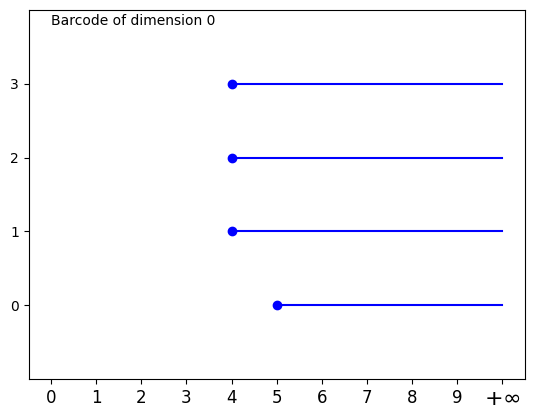

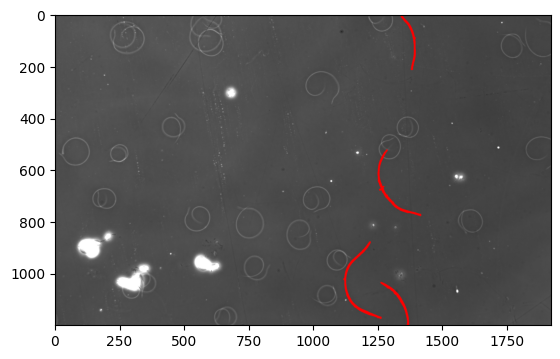

In [4]:
# If the video is not in the same folder as this Jupyter notebook, please modify the following line to include the 
# correct path.
video = "acA1920-155um__22949301__20220524_161628299.avi" 
imgList = zigzagPersistenceStaticDetection(video)
# We show one of the frames
plt.imshow(imgList[30])


### Example 2: tracking of motile spermatozoa

We now proceed to detect and track the motile spermatozoa in the videos using zigzag persistence in dimension 1.

In [5]:
        
def zigzagPersistenceCirclesDetection (video, show_frames = False):
    
    # Filters and parameters as presented by the CASABee software. 
    # Indeed, most part of this code is taken from it: we only want to change the tracking step.
    filterKernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    morphKernel = np.ones((3,3),np.uint8) 
    horizontalLinesKernel = np.array([[-1,-1,-1],[2,2,2],[-1,-1,-1]])
    verticalLinesKernel = np.array([[-1,2,-1],[-1,2,-1],[-1,2,-1]])
    kernel45Lines = np.array([[-1,-1,2],[-1,2,-1],[2,-1,-1]])
    kernel_45Lines = np.array([[2,-1,-1],[-1,2,-1],[-1,-1,2]])


    boundingBoxMinArea = 600 #
    th=70
    minRadius = 35 # 35 
    maxRadius =  50 # 50
    micronsPerPixel = 0.59
    cameraDepth = 10 # in microns
    mediumCellSize = 180 # in microns
    mediumCellSize = mediumCellSize / micronsPerPixel # in pixels
    minimumCellSize = mediumCellSize * 0.20
    minArea = minimumCellSize * 4 
    
    vidcap = cv.VideoCapture(video)
    success,image = vidcap.read()
    
    circleList = []
    cimgList = []
    
    if success:
        height, width, depth = image.shape
        iimg = np.full((height,width),255,np.uint8)
        w=width+50
        h=height+50    
        
    imgList = []


    while success:
        cimgList.append(image)
        image = cv.cvtColor(image,cv.COLOR_BGR2GRAY)
        cv.normalize(image, image, 0, 255, cv.NORM_MINMAX)
        image = cv.filter2D(image, -1, filterKernel)
        img_border = cv.copyMakeBorder(image, 50, 50, 50, 50, cv.BORDER_REFLECT) 

        # For the Hough circle transform (used as a detector), we use the same parameters as CASABee. 
        # Note that the optimal parameters could be different for each video (as in CASABee).
        circles = cv.HoughCircles(img_border,cv.HOUGH_GRADIENT,1,50,param1=80,param2=35,minRadius=minRadius,
                                  maxRadius=maxRadius)
        circles = np.uint16(np.around(circles))
        # I choose the circles that are inside the image 
        circles2 = []
        for (x,y,r) in circles[0,:]:
 
            if ((x>=50) and x<=w and (y>=50) and y<=h):
                mask = np.zeros((height, width),np.uint8)
                cv.circle(mask,(x,y),r,255,-1)
                points = np.transpose(np.where(mask==255))
                sum=0
                for (a,b) in points:
                    sum = sum + img_border[a][b]
                
                if(sum <= 128*0.6*len(points)):
                    circles2.append([x-50,y-50,r])

        threshold,img_umb = cv.threshold(image,th,255,255)

        if circles2 is not None:
            for (x,y,r) in circles2:
                cv.circle(img_umb,(x,y),45,255,25)                

        img = img_umb
        scale_percent = 15 # percent of original size
        width = int(img.shape[1] * scale_percent / 100)
        height = int(img.shape[0] * scale_percent / 100)
        dim = (width, height)
  
        # We resize the image to be able to compute the zigzag in a reasonable time
        resized = cv.resize(img, dim) #, interpolation = cv.INTER_AREA)
        threshold,resized2 = cv.threshold(resized,100, 255, cv.THRESH_BINARY)
        imgList.append(resized2)
        success,image = vidcap.read()
      
    i=0
    num = 3
    zigzagImageList = []
    while (i < len(imgList)/num):
        img = imgList[i*num]
        j = 1
        while j<num and i*num+j < len(imgList):
            img = cv.bitwise_or(img, imgList[i*num+j])
            j = j+1
        zigzagImageList.append(img)
        #plt.imshow(img)
        #plt.show()
        i = i +1
        
    l1 = zigzagImageList
    im = l1[0]
    if show_frames:
        for i in range(1,len(l1)):
            im2= l1[i] 
            im3=cv.bitwise_and(im, im2)
            plt.imshow(im3)
            plt.show()
            im = im2
    
    generators = imageListZigzagPlotBar(zigzagImageList,dimensions=[1],interval_l=11,printGenerators = False)

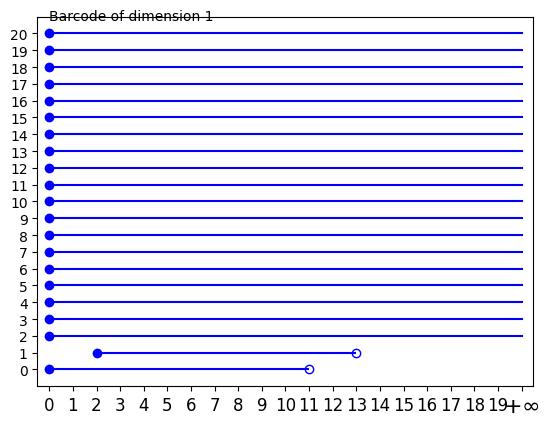

In [6]:
# If the video is not in the same folder as this Jupyter notebook, please modify the following line with the 
# correct path.
video = "acA1920-155um__22949301__20220524_161628299.avi"
zigzagPersistenceCirclesDetection(video) # This may take some time.